In [74]:
import sys
import os
import numpy as np
import pandas as pd
import pymatgen as mg
import matplotlib.pyplot as plt
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator
import ternary
import seaborn as sn
import re
import colorcet as cc
from scipy.optimize import minimize
from scipy.integrate import quad
from scipy.special import erf

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, WhiteKernel, RBF, Matern
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# add custom modules
module_dir = '../modules'
if module_dir not in sys.path:
    sys.path.append(module_dir)
# imports from ../modules
from pickle_tools import save_pickle, load_pickle
import model_eval as mv
from BCA_featurizer import BCA_Featurizer, GenericFeaturizer, mpcalc, ON_BondEnergyDelta
from bca_plotting import get_coords_from_comp, add_colorbar, plot_labeled_ternary, featurize_simplex, \
    estimator_ternary_heatmap, scatter_over_heatmap, draw_guidelines, BCA_formula_from_str

# add alepython directory
ale_dir = os.path.join(os.environ['HOME'],'onedrive - colorado school of mines\\python\\cloned_repos\\ALEpython')
if ale_dir not in sys.path:
    sys.path.append(ale_dir)
from alepython import ale

%load_ext autoreload
%autoreload 2

Created MatProjCalc instance


../modules\BCA_featurizer.py:322: UserWarning:

Using VASP data for formation enthalpy of BH3

../modules\BCA_featurizer.py:315: UserWarning:

Using VASP data for formation enthalpy of Sr3N2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 0. Data Setup

In [18]:
basedatadir = '../data'
plotdir = '../images'
latexdir = '../../latex/figures'
datadirs = next(os.walk(basedatadir))[1]

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'dejavu serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['image.cmap'] = 'cet_rainbow'

## 0.1 Load experimental data

In [24]:
all_data = pd.read_csv('../data/BCA_AggData.csv')
all_data['composition'] = all_data['formula'].map(lambda x: mg.Composition(x))
# separate train/validation and test data
tv_data = all_data[all_data['split']=='train_val'].copy()
test_data = all_data[all_data['split']=='test'].copy()

In [13]:
# estimate uncertainty from repeated B2CA measurements
b2ca_data = all_data[all_data['BCA_str']=='B2C1A1']
b2ca_std = np.std(b2ca_data['max_rate'])
b2ca_mean = np.mean(b2ca_data['max_rate'])

print('B2CA mean rate:',b2ca_mean)
print('B2CA rate std:',b2ca_std)

# Assume rate std comprises a constant resolution std and a proportional std
# b2ca_std^2 = sigma_res^2 + sigma_prop^2
# sigma_prop = b2ca_mean*alpha_prop
sigma_res = 5
sigma_prop = np.sqrt(b2ca_std**2 - sigma_res**2)
alpha_prop = sigma_prop/b2ca_mean
sigma_prop, b2ca_std, alpha_prop

print('alpha_prop:',alpha_prop)

B2CA mean rate: 164.7232
B2CA rate std: 22.976221712022188
alpha_prop: 0.13614100992063474


<IPython.core.display.Javascript object>


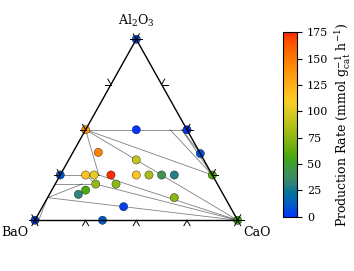

In [19]:
# Plot all experimental rates
label_fs = 9
tick_fs = 8
vlim = (0,175)

comp_mean_data = all_data.groupby('composition').mean()

fig,ax = plt.subplots(figsize=(3.54,3.54*6.9/9))


# ax1: Ternary scatter of data
#------------------------------
tax1 = plot_labeled_ternary(comp_mean_data.index,comp_mean_data['max_rate'],add_labeloffset=0.05,
                            label_points=False,corner_labelsize=label_fs,edgecolor='k',ax=ax,linewidth=0.25,
                            cmap=cc.m_rainbow,marker='o',s=35#10*np.log(all_data['norm_max_rate']),vlim=vlim
                           )

# # emphasize B2CA with larger marker and bold outline
# tax1.scatter([[0.25,0.25,0.5]],s=45,c=[b2ca_mean],edgecolor='k')
tax1.ticks(multiple=0.25,tick_formats='',offset=0.03,lw=0.7)
tax1.ticks(multiple=0.25,tick_formats='',offset=0.03,lw=0.7,clockwise=True)

draw_guidelines(tax1,color='k',alpha=0.5,lw=0.6,zorder=0)

add_colorbar(ax=ax,vlim=vlim,cbrect=[0.8,0.2,0.04,0.68],
             subplots_adjust={'left':0.07,'wspace':0.35, 'hspace':0.25, 'right':0.7},
             label='Synthesis Rate ($\mathrm{mmol} \ \mathrm{g}_{\mathrm{cat}}^{-1} \ \mathrm{h}^{-1}$)',
             label_kwargs={'size':label_fs},tick_params={'labelsize':tick_fs})

fig.savefig(os.path.join(plotdir,'BCA_ExpProdRate_TernaryScatter.pdf'),dpi=500,format='pdf')
fig.savefig(os.path.join(latexdir,'BCA_ExpProdRate_TernaryScatter.pdf'),dpi=300,format='pdf')

<IPython.core.display.Javascript object>


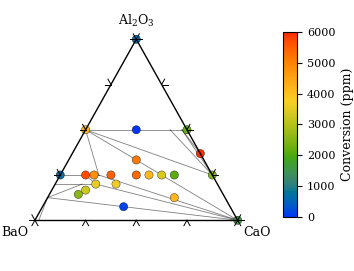

In [22]:
# Plot all experimental conversion
label_fs = 9
tick_fs = 8
vlim = (0,6000)

comp_mean_data = all_data.groupby('composition').mean()

fig,ax = plt.subplots(figsize=(3.54,3.54*6.9/9))


# ax1: Ternary scatter of data
#------------------------------
tax1 = plot_labeled_ternary(comp_mean_data.index,comp_mean_data['max_NH3_ppm'],add_labeloffset=0.05,
                            label_points=False,corner_labelsize=label_fs,edgecolor='k',ax=ax,linewidth=0.25,
                            cmap=cc.m_rainbow,marker='o',s=35#10*np.log(all_data['norm_max_rate']),vlim=vlim
                           )

# # emphasize B2CA with larger marker and bold outline
# tax1.scatter([[0.25,0.25,0.5]],s=45,c=[b2ca_mean],edgecolor='k')
tax1.ticks(multiple=0.25,tick_formats='',offset=0.03,lw=0.7)
tax1.ticks(multiple=0.25,tick_formats='',offset=0.03,lw=0.7,clockwise=True)

draw_guidelines(tax1,color='k',alpha=0.5,lw=0.6,zorder=0)

add_colorbar(ax=ax,vlim=vlim,cbrect=[0.8,0.2,0.04,0.68],
             subplots_adjust={'left':0.07,'wspace':0.35, 'hspace':0.25, 'right':0.7},
             label='Conversion (ppm)',
             label_kwargs={'size':label_fs},tick_params={'labelsize':tick_fs})

## 0.2 Featurize compositions

In [26]:
bf = BCA_Featurizer()
bf.set_n_jobs(1)

print('Number of available features:', len(bf.feature_labels()))

tv_features = bf.featurize_dataframe(tv_data,col_id="composition",inplace=False)

"Set up train and validation datasets"
# val_idx = [16, 12, 4, 22]
# split init set into train and validation sets

# don't allow compositions in the training set to appear in the validation set
val_avail = tv_features[~tv_features['BCA_str'].isin(['B2C1A1','B0C3A1'])].index
rng = np.random.RandomState(seed=8)
val_idx = rng.choice(val_avail,size=5,replace=False)

X_train = tv_features[~tv_features.index.isin(val_idx)].loc[:,'MO_ratio':]
y_train = tv_features[~tv_features.index.isin(val_idx)].loc[:,['max_rate','max_NH3_ppm']]
X_val = tv_features.loc[val_idx,'MO_ratio':]
y_val = tv_features.loc[val_idx,['max_rate','max_NH3_ppm']]

# check all features are numeric
print("Feature datatypes:", X_train.dtypes.unique())
# remove zero-var features
zero_var = list(X_train.columns[X_train.var()==0])
X_train = X_train.drop(zero_var,axis=1)
print("Zero variance features removed:", zero_var)
# remove null features
nulls = list(X_train.columns[pd.isnull(X_train).max()])
X_train = X_train.drop(nulls,axis=1)
X_val_gen = X_val.drop(nulls,axis=1)
print("Null features removed:", nulls)
print('\nFinal number of features:', len(X_train.columns))
Xy_train = pd.concat([X_train,y_train],axis=1)
Xy_val = pd.concat([X_val,y_val],axis=1)
Xy_tv = pd.concat([Xy_train,Xy_val],sort=True)

"Set up test dataset"
# test_data = data[(data['batch']=='test') & (data['BCA_str']!='B2C1A1')]
test_features = bf.featurize_dataframe(test_data,col_id="composition",inplace=False)
# remove features that had zero variance in training data
X_test = test_features.loc[:,'MO_ratio':]
X_test = X_test.drop(zero_var+nulls,axis=1)
y_test = test_features[['max_rate','max_NH3_ppm']]
Xy_test = pd.concat([X_test,y_test],axis=1)

"Full dataset"
Xy_all = pd.concat([Xy_tv,Xy_test],sort=True)

Number of available features: 104



Feature datatypes: [dtype('float64')]
Zero variance features removed: ['M_ValenceElec_s_mean', 'M_ValenceElec_d_mean', 'M_ValenceElec_f_mean', 'M_ValenceElec_d_frac', 'M_ValenceElec_f_frac']
Null features removed: ['BCA_bulk_mod_mean', 'BCA_bulk_mod_std', 'BCA_shear_mod_mean', 'BCA_shear_mod_std']

Final number of features: 95


<IPython.core.display.Javascript object>


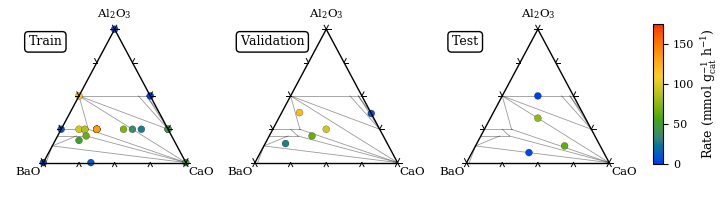

In [39]:
fig, axes = plt.subplots(1,3,figsize=(7.25,2))

dfs = [tv_features.loc[X_train.index,:], tv_features.loc[X_val.index,:], test_features]
for ax,df,title in zip(axes,dfs,['Train','Validation','Test']):
    
    tax = plot_labeled_ternary(df['composition'],df['max_rate'],
                               s=25,point_labeloffset=[-0.01,0.015,0],add_labeloffset=0.06,
                               label_points=False,corner_labelsize=8.5,vlim=(0,200),ax=ax,ec='k',lw=0.15
                              )
    tax.ticks(multiple=0.25,tick_formats='',offset=0.03,lw=0.7)
    tax.ticks(multiple=0.25,tick_formats='',offset=0.03,lw=0.7,clockwise=True)
    # plot b2ca with outline (hard to see with light color fill)
#     b2ca = df[df['BCA_str']=='B2C1A1']
#     if len(b2ca) > 0:
#         tax.scatter([get_coords_from_comp(c) for c in b2ca['composition']],c=b2ca['max_rate'],vmin=0,vmax=175,
#                     edgecolor='k',lw=0.5,s=25
#                    )

    draw_guidelines(tax,color='k',alpha=0.4,lw=0.6,zorder=0)
    ax.set_title(title,x=-0.05,y=0.83,size=9,ha='left',va='center',bbox={'boxstyle':'round','facecolor':'white'})


add_colorbar(fig,label='Rate (mmol g$_{\mathrm{cat}}^{-1}$ h$^{-1}$)',vlim=(0,175),
             label_kwargs={'size':9},tick_params={'labelsize':8},
            subplots_adjust={'left':0.05,'right':0.85,'wspace':0.35},cbrect=[0.9,0.18,0.015,0.7])

fig.savefig(os.path.join(plotdir,'SuppFig_TrainValTestData.jpg'),dpi=300)
fig.savefig(os.path.join(latexdir,'SuppFig_TrainValTestData.jpg'),dpi=300)

<IPython.core.display.Javascript object>


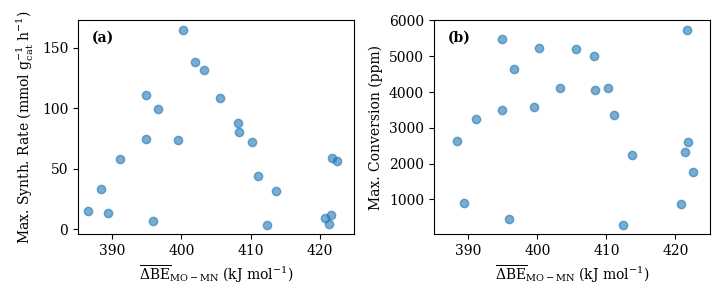

In [68]:
# Plot max rate and max conversion vs. BE_MO-MN
fig,axes = plt.subplots(1,2,figsize=(7.25,3))
x_var = 'ON_BondEnergyDelta_mean'
x_tmp = pd.concat((all_data,Xy_all[x_var]),axis=1)
comp_mean_tmp = x_tmp.groupby('composition').mean()

ycols = ['max_rate','max_NH3_ppm']

for ax, col in zip(axes.ravel(),ycols):
    ax.scatter(comp_mean_tmp[x_var],comp_mean_tmp[col],alpha=0.6)
#     ax.set_xlim(385,420)
    ax.set_xlabel('$\overline{\Delta\mathrm{BE}}_{\mathrm{MO-MN}}$ (kJ mol$^{-1}$)')
    ax.set_xlim(385,425)
    
axes[0].set_ylabel('Max. Synth. Rate (mmol g$_{\mathrm{cat}}^{-1}$ h$^{-1}$)')
axes[1].set_ylabel('Max. Conversion (ppm)')

# subfig labels
for ax, let in zip(axes,['a','b']):
    ax.text(0.05,0.95,f'({let})',weight='bold',size=label_fs+1,transform=ax.transAxes,va='top')

fig.tight_layout()
fig.savefig(os.path.join(plotdir,'SuppFig_RateAndConv_vs_ONBED.jpg'),dpi=300)
fig.savefig(os.path.join(latexdir,'SuppFig_RateAndConv_vs_ONBED.jpg'),dpi=300)

# 1. Physical model

In [45]:
target = 'max_rate'

model_features1 = ['ON_BondEnergyDelta_mean','M_WorkFunction_mean']

rf1 = RandomForestRegressor(random_state=11)

## 1.1 Hyperparameter optimization via grid search

In [46]:
index = ~pd.isnull(y_train[target])
X_gs = X_train.loc[index,model_features1].values
y_gs = y_train.loc[index,target].values

# due to small sample size, CV is quite sensitive to train-validation splits
# use repeated CV with multiple different splits to get relatively unbiased results
gs_rf1 = mv.GridSearchRepeatedCV(rf1,param_grid={'n_estimators':[40,50,60,70],
                                                'max_features':np.arange(1,len(model_features1)+1,1).astype(int),
                                                'max_depth':[3,5,7]
                                               }
                               )
gs_rf1.fit(X_gs,y_gs,repeat=4,n_splits=4,random_state=17)

<IPython.core.display.Javascript object>


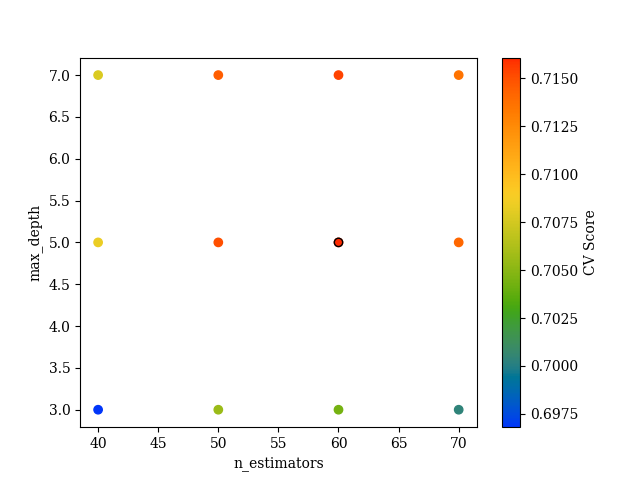

In [48]:
gs_rf1.plot_grid_results(fixed_params={'max_features':gs_rf1.best_params_['max_features']})

In [49]:
gs_rf1.best_params_,gs_rf1.best_score_
# should be 60, 2, 5, 0.71665

({'n_estimators': 60, 'max_features': 2, 'max_depth': 5}, 0.7160782771384102)

## 1.2 Cross-validation and holdout validation with optimized hyperparameters

<IPython.core.display.Javascript object>


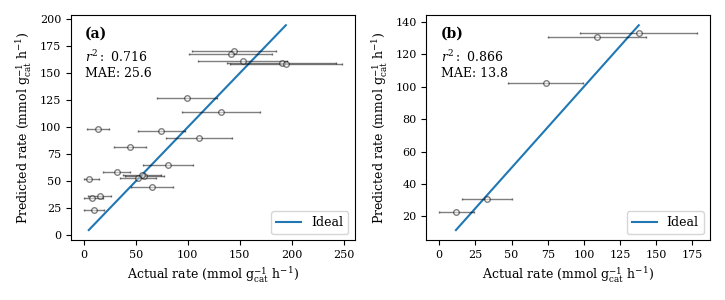

In [51]:
# Cross validation and holdout
rf1.set_params(**gs_rf1.best_params_)

label_fs = 9
tick_fs = 8
fig, axes = plt.subplots(1,2,figsize=(7.25,3))#,sharex=True,sharey=True)

# constant resolution std of 10 mmol/gh, proportional resolution std of ~12% of rate
sigma = np.array([np.sqrt(sigma_res**2 + (alpha_prop*y)**2) for y in y_train[target]])

# 95% confidence interval: +/- 2*sigma
# don't allow the errorbars to go negative
xerr_up = 2*sigma
xerr_down = [min(2*s,y) for s,y in zip(sigma,y_train[target])]
xerr = np.stack((xerr_down,xerr_up))
actuals, preds, test_r2, test_mae,lbs,ubs = \
    mv.repeated_KFold_pva(rf1,X_train.loc[:,model_features1].values,y=y_train[target].values,repeat=4,
                      xerr=xerr, #pred_int = 0.682,
                      n_splits=4,plot_type='mean',ax=axes[0],random_state=17,
                      show_metrics=['r2','mae'],
                      marker='.',s=8,ls='',capsize=1,c='k',elinewidth=1,markerfacecolor='white',alpha=0.5,
                      text_kw={'size':label_fs,'y':0.85}
                     )

custom_cv_score = np.mean(test_r2)

# plot validation (holdout) pva
rf1.fit(X_train.loc[:,model_features1].values,y_train[target].values)
xerr_up = [10+y*0.22 for y in y_val[target]]
xerr_down = [min(10+y*0.22,y) for y in y_val[target]]
xerr = np.stack((xerr_down,xerr_up))
mv.plot_pva(rf1,X_val.loc[:,model_features1].values,y=y_val[target].values,ax=axes[1],            
            xerr=xerr, #pred_int=0.682,
            show_metrics=['r2','mae'],legend=False,
            marker='.',s=8,ls='',capsize=1,c='k',elinewidth=1,markerfacecolor='white',alpha=0.5,
            text_kw={'size':label_fs,'y':0.85}
           )

custom_val_score = rf1.score(X_val.loc[:,model_features1].values,y=y_val[target].values)

for ax in axes:
    ax.tick_params(axis='both',labelsize=tick_fs)
    ax.set_xlabel('Actual rate (mmol g$_{\mathrm{cat}}^{-1}$ h$^{-1}$)',size=label_fs)
    ax.set_ylabel('Predicted rate (mmol g$_{\mathrm{cat}}^{-1}$ h$^{-1}$)',size=label_fs)
    ax.legend(loc='lower right',fontsize=label_fs)

# axes[0].set_title('4-Fold Cross Validation',size=label_fs+1)
# axes[1].set_title('Holdout Validation',size=label_fs+1)
for ax, let in zip(axes,['a','b']):
    ax.text(0.05,0.95,f'({let})',weight='bold',size=label_fs+1,transform=ax.transAxes,va='top')

    
fig.tight_layout()
fig.savefig(os.path.join(plotdir,'SuppFig_ModelValidationPVA.jpg'),dpi=300)
fig.savefig(os.path.join(latexdir,'SuppFig_ModelValidationPVA.jpg'),dpi=300)

In [1364]:
# point predicted in CV at ~90 when actual is 13: B3A

## 1.3 Test set

In [52]:
# generate heatmap features
scale = 50
coords, X_simplex = featurize_simplex(scale,bf)
X_hm1 = X_simplex.loc[:,model_features1]

<IPython.core.display.Javascript object>


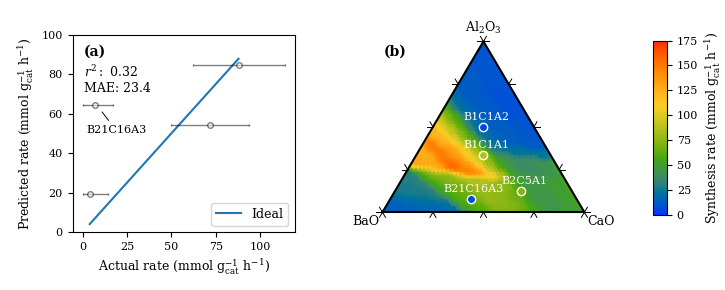

In [57]:
# plot test set vs. predictions
fig, axes = plt.subplots(1,2,figsize=(7.25,2.9))
label_fs = 9
tick_fs = 8

# ensure model is fit to Xy_tv
rf1.fit(Xy_tv.loc[:,model_features1].values,Xy_tv[target].values)

# PVA
# constant resolution std of 10 mmol/gh, proportional resolution std of ~12% of rate
sigma = np.array([np.sqrt(sigma_res**2 + (alpha_prop*y)**2) for y in y_test[target]])
xerr_up = 2*sigma
xerr_down = [min(2*s,y) for s,y in zip(sigma,y_test[target])]
xerr = np.stack((xerr_down,xerr_up))
mv.plot_pva(rf1,X_test.loc[:,model_features1].values,y_test[target].values,ax=axes[0],
            xerr=xerr,pred_int=0,
            show_metrics=['r2','mae'],legend=True,
            marker='.',s=8,ls='',capsize=1,c='k',elinewidth=1,markerfacecolor='white',alpha=0.5,
            text_kw={'size':label_fs,'y':0.85}
           )

axes[0].set_ylim(0,100)
axes[0].legend(fontsize=label_fs,loc='lower right')
axes[0].set_xlabel('Actual rate (mmol g$_{\mathrm{cat}}^{-1}$ h$^{-1}$)',size=label_fs)
axes[0].set_ylabel('Predicted rate (mmol g$_{\mathrm{cat}}^{-1}$ h$^{-1}$)',size=label_fs)
axes[0].tick_params(labelsize=tick_fs)

axes[0].text(0.05,0.95,'(a)',va='top',transform=axes[0].transAxes,weight='bold',size=label_fs+1)
axes[0].annotate('B21C16A3',(10,62),xytext=(2,50),size=tick_fs,arrowprops={'arrowstyle':'-','lw':0.7})

# heatmap
vlim = (0,175)
# tax = plot_labeled_ternary(test_data['composition'],test_data['norm_max_rate'],ax=axes[1])
tax = scatter_over_heatmap(test_data['composition'],test_data['max_rate'],50,rf1,
                           hmap_use_X=X_hm1,point_labeloffset=[0,0.03,0],
                           scatter_labels=test_data['BCA_str'],
                           ax=axes[1],add_labeloffset=0.03,vlim=vlim,cmap=cc.m_rainbow,
                           corner_labelsize=label_fs,markersize=6,scatter_labelsize=tick_fs
                          )

tax.ticks(multiple=50/4,tick_formats='',offset=0.03,lw=0.7)
tax.ticks(multiple=50/4,tick_formats='',offset=0.03,lw=0.7,clockwise=True)

axes[1].text(0.05,0.95,'(b)',va='top',transform=axes[1].transAxes,weight='bold',size=label_fs+1)

add_colorbar(ax=axes[1],vlim=vlim,cbrect=[0.9,0.26,0.02,0.6],
             subplots_adjust={'left':0.1,'wspace':0.35, 'hspace':0.25, 'right':0.82,'bottom':0.2},
             label='Synthesis rate (mmol g$_{\mathrm{cat}}^{-1}$ h$^{-1}$)',label_kwargs={'size':label_fs},
             tick_params={'labelsize':tick_fs}
            )

fig.savefig(os.path.join(plotdir,'SuppFig_TestPVA.jpg'),dpi=300)
fig.savefig(os.path.join(latexdir,'SuppFig_TestPVA.jpg'),dpi=300)

## 1.4 Generate prediction heatmap 

<IPython.core.display.Javascript object>


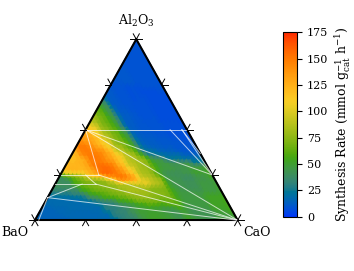

In [54]:
# ternary heatmap of model predictions
fig,ax = plt.subplots(figsize=(3.54,3.54*6.9/9))

# ensure model is fit to Xy_all
rf1.fit(Xy_all.loc[:,model_features1].values,Xy_all[target].values)

vlim = (0,175)
tax2 = estimator_ternary_heatmap(50,rf1,use_X=X_hm1,ax=ax,add_labeloffset=0.05,vlim=vlim,cmap=cc.m_rainbow,
                               labelsize=label_fs)

draw_guidelines(tax2,color='white',lw=0.7,alpha=0.7)

tax2.ticks(multiple=tax2.get_scale()/4,tick_formats='',offset=0.03,lw=0.7)
tax2.ticks(multiple=tax2.get_scale()/4,tick_formats='',offset=0.03,lw=0.7,clockwise=True)

add_colorbar(ax=ax,vlim=vlim,cbrect=[0.8,0.2,0.04,0.68],
             subplots_adjust={'left':0.07,'wspace':0.35, 'hspace':0.25, 'right':0.7},
             label='Synthesis Rate ($\mathrm{mmol} \ \mathrm{g}_{\mathrm{cat}}^{-1} \ \mathrm{h}^{-1}$)',
             label_kwargs={'size':label_fs},tick_params={'labelsize':tick_fs})

fig.savefig(os.path.join(plotdir,'BCA_ML_heatmap.pdf'),dpi=500,format='pdf')
fig.savefig(os.path.join(plotdir,'BCA_ML_heatmap.jpg'),dpi=500)

## 1.5 Reproduce phase diagram

<IPython.core.display.Javascript object>


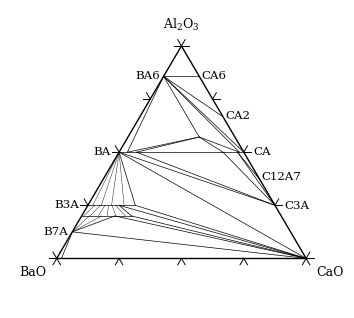

In [73]:
# phase diagram
fig,ax = plt.subplots(figsize=(3.54,3.54*8.1/9))

tax3 = ternary.TernaryAxesSubplot(ax=ax)
tern_labels = ['CaO','Al$_2$O$_3$','BaO']
add_labeloffset=0.05
tax3.right_corner_label(tern_labels[0],fontsize=label_fs,va='center',offset=0.08+add_labeloffset)
tax3.top_corner_label(tern_labels[1],fontsize=label_fs,va='center',offset=0.05+add_labeloffset)
tax3.left_corner_label(tern_labels[2],fontsize=label_fs,va='center',offset=0.08+add_labeloffset)
tax3.boundary(linewidth=1)
ax.axis('off')
tax3._redraw_labels()

# load phase diagram data and plot
ped_data = pd.read_csv(os.path.join(basedatadir,'BCA_PED_coords.csv'),skipfooter=2,engine='python')
for col in ['start','end']:
    ped_data[f'{col}_comp'] = ped_data[f'{col}'].map(lambda x: mg.Composition(BCA_formula_from_str(x)))
    ped_data[f'{col}_coords'] = ped_data[f'{col}_comp'].map(get_coords_from_comp)
for i, row in ped_data.iterrows():
    if row['type']=='boundary':
        lw=0.5
    elif row['type']=='tie':
        lw=0.3
    tax3.line(row['start_coords'],row['end_coords'],lw=lw,c='k')

# tax3.annotate('BA',(-0.03,0.5,0.5),ha='right',va='center',size=label_fs-0.5)
# tax3.annotate('B$_3$A',(-0.03,0.25,0.75),ha='right',va='center',size=label_fs-0.5)
# tax3.annotate('CaO + B$_3$A\n+ BA',(0.27,0.28,0.45),ha='center',va='center',size=label_fs-4)

tax3.annotate('BA6',(-0.015,0.857,0.143),ha='right',va='center',size=label_fs-0.5)
tax3.annotate('BA',(-0.035,0.5,0.5),ha='right',va='center',size=label_fs-0.5)
tax3.annotate('B3A',(-0.035,0.25,0.75),ha='right',va='center',size=label_fs-0.5)
# tax3.annotate('B$_4$A',(-0.015,0.2,0.8),ha='right',va='center',size=label_fs-0.5)
tax3.annotate('B7A',(-0.015,0.125,0.875),ha='right',va='center',size=label_fs-0.5)

# tax3.annotate('CaO + B$_3$A\n+ BA',(0.27,0.28,0.45),ha='center',va='center',size=label_fs-0.5)
tax3.annotate('C3A',(0.79,0.245,0),ha='left',va='center',size=label_fs-0.5)
tax3.annotate('C12A7',(0.63,0.385,0),ha='left',va='center',size=label_fs-0.5)
tax3.annotate('CA',(0.54,0.50,0),ha='left',va='center',size=label_fs-0.5)
tax3.annotate('CA2',(0.34,0.67,0),ha='left',va='center',size=label_fs-0.5)
tax3.annotate('CA6',(0.15,0.857,0),ha='left',va='center',size=label_fs-0.5)

tax3.ticks(multiple=0.25,tick_formats='',offset=0.03,lw=0.7)
tax3.ticks(multiple=0.25,tick_formats='',offset=0.03,lw=0.7,clockwise=True)

fig.savefig(os.path.join(plotdir,'BCA_PhaseDiagram_1250C.pdf'),dpi=500,format='pdf')

## 1.6 Feature dependence plots

<IPython.core.display.Javascript object>


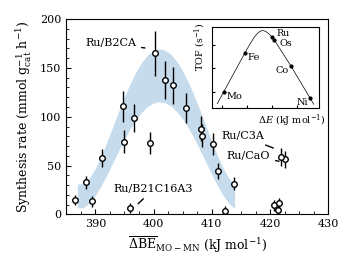

C:\Users\jdh10\anaconda3\envs\matsci\lib\site-packages\ipykernel_launcher.py:79: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



In [61]:
# volcano plot

fig,ax4 = plt.subplots(figsize=(3.54,2.7))

x_tmp = pd.concat((all_data,Xy_all['ON_BondEnergyDelta_mean']),axis=1)
comp_mean_tmp = x_tmp.groupby('composition').mean()

sigma_tot = (sigma_res**2 + (comp_mean_tmp['max_rate']*alpha_prop)**2)**0.5

ax4.errorbar(comp_mean_tmp['ON_BondEnergyDelta_mean'],comp_mean_tmp['max_rate'],
             yerr=sigma_tot,#5+comp_mean_tmp['norm_max_rate']*.11,
            marker='.',ms=8,ls='',capsize=0,c='k', elinewidth=1,markerfacecolor='white'
           )
ax4.set_xlim(385,430)
ax4.set_ylim(0,200)
ax4.set_xlabel('$\overline{\Delta\mathrm{BE}}_{\mathrm{MO-MN}}$ (kJ mol$^{-1}$)',size=label_fs)
ax4.set_ylabel('Synthesis rate ($\mathrm{mmol} \ \mathrm{g}_{\mathrm{cat}}^{-1} \ \mathrm{h}^{-1}$)',size=label_fs)

ax4.annotate('Ru/B2CA',(399,170),xytext=(397,175),size=label_fs-1,
             arrowprops={'arrowstyle':'-'},va='center',ha='right')
ax4.annotate('Ru/CaO',(422,54),xytext=(420,60),size=label_fs-1,ha='right',arrowprops={'arrowstyle':'-'},va='center')
ax4.annotate('Ru/C3A',(421,67),xytext=(419,80),size=label_fs-1,ha='right',arrowprops={'arrowstyle':'-'},va='center')
ax4.annotate('Ru/B21C16A3',(397,9),xytext=(400,26),size=label_fs-1,ha='center',
             arrowprops={'arrowstyle':'-'},va='center')

# ax4.annotate('Ru/C12A7:e$^-$',(422,12),xytext=(423,32),size=label_fs-1,ha='center',
#              arrowprops={'arrowstyle':'-'},va='center')

ax4.xaxis.set_minor_locator(MultipleLocator(2.5))
ax4.yaxis.set_major_locator(MultipleLocator(50))
ax4.yaxis.set_minor_locator(MultipleLocator(10))
ax4.tick_params(axis='both',which='both',direction='in',labelsize=tick_fs)

# add a rough fit to highlight the shape
# exclude C3A, CaO, BaO
fit_data = comp_mean_tmp[(380<comp_mean_tmp['ON_BondEnergyDelta_mean']) & (comp_mean_tmp['ON_BondEnergyDelta_mean']<415)]
# exclude deviating points from fit
ignore = [mg.Composition(c) for c in ['(BaO)21(CaO)16(Al2O3)3','(BaO)5(CaO)3(Al2O3)2']]
fit_data = fit_data[~fit_data.index.isin(ignore)]
fit = np.polyfit(fit_data['ON_BondEnergyDelta_mean'],fit_data['max_rate'],deg=4)
x_fit = np.arange(387,415,1)
y_fit = np.polyval(fit,x_fit)
ax4.fill_between(x_fit,y_fit*0.88-10,y_fit*1.12+10,alpha=0.25,edgecolor='none')

# ax4 inset: pure metal volcano plot
#-------------------------------------
ax4i = fig.add_axes([0.6,0.6,0.3,0.3])
volcano_data = pd.read_csv(os.path.join(basedatadir,'MetalVolcanoData.csv'),skipfooter=2,engine='python')

elmt_data = volcano_data[volcano_data['Element']!='Curve']
curve_data = volcano_data[volcano_data['Element']=='Curve']
# plot curve
ax4i.plot(curve_data['E'],curve_data['TOF'],c='k',zorder=0,lw=0.5)
# plot pure metals
ax4i.scatter(elmt_data[elmt_data['Element']!='CoMo']['E'],elmt_data[elmt_data['Element']!='CoMo']['TOF'],c='k',s=4)
# plot CoMo
# ax4i.scatter(elmt_data[elmt_data['Element']=='CoMo']['E'],elmt_data[elmt_data['Element']=='CoMo']['TOF'],edgecolors='k',
#            facecolors='white',zorder=1,s=5
#           )
# element labels
for el in ['Fe','Mo']:
    el_pt = elmt_data[elmt_data['Element']==el]
    ax4i.text(el_pt['E']+5,el_pt['TOF'],el,size=7,ha='left',va='top')
for el in ['Co','Ni']:
    el_pt = elmt_data[elmt_data['Element']==el]
    ax4i.text(el_pt['E']-5,el_pt['TOF'],el,size=7,ha='right',va='top') 
ax4i.text(10,20,'Ru',size=7,ha='left',va='top')
ax4i.text(15,3,'Os',size=7,ha='left',va='top')

ax4i.set_yscale('log')
ax4i.tick_params(axis='both',direction='in',length=2)
ax4i.set_xticks(np.arange(-100,76,50))
ax4i.set_yticks([1e-4,1e-2,1])
ax4i.set_xticklabels([])
ax4i.set_yticklabels([])
ax4i.set_xlabel('$\Delta E$ (kJ mol$^{-1}$)',size=7,x=0.75,labelpad=0)
ax4i.set_ylabel('TOF (s$^{-1}$)',size=7,y=0.75,labelpad=0)

fig.tight_layout()
fig.savefig(os.path.join(plotdir,'ProdRate_vs_BE_volcano.pdf'),dpi=300,format='pdf')

<IPython.core.display.Javascript object>


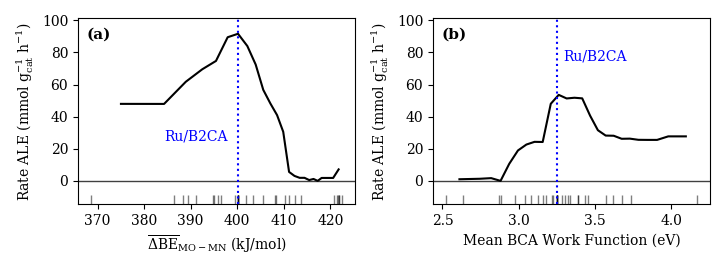

In [69]:
# Accumulated local effects (ALE) plots

# ensure model is trained on Xy_all
rf1.fit(Xy_all.loc[:,model_features1].values,Xy_all[target].values)
# 'train_set' is actually full ternary feature map - get predictions for full composition space
train_set = X_hm1.loc[:,model_features1]
fig, axes = plt.subplots(1,2,figsize=(7.25,2.7))
bins = 25
feature_labels = ['$\overline{\Delta\mathrm{BE}}_{\mathrm{MO-MN}}$ (kJ/mol)', 'Mean BCA Work Function (eV)']
for feature,xlabel,ax in zip(model_features1,feature_labels,axes):
    
    quantiles = np.percentile(train_set[feature], [1. / bins * i * 100 for i in range(0, bins + 1)])
    ALE = ale._first_order_ale_quant(rf1.predict, train_set,feature,quantiles)

    ale._first_order_quant_plot(ax,quantiles,ALE-np.min(ALE),c='k')
    # plot distribution of actual training points in rugplot
    sn.rugplot(Xy_all[feature],ax=ax,c='k',alpha=0.5)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Rate ALE ($\mathrm{mmol} \ \mathrm{g}_{\mathrm{cat}}^{-1} \ \mathrm{h}^{-1}$)')
    # make room for rug plot at bottom and empty space at top
    ax.set_ylim(ax.get_ylim()[0]-10,ax.get_ylim()[1]+5)
    

for ax,let in zip(axes,['(a)','(b)']):
    # set same ylims for both
    ax.set_ylim(np.min([ax.get_ylim()[0] for ax in axes]), np.max([ax.get_ylim()[1] for ax in axes]))
    ax.axhline(0,c='k',ls='-',lw=1,alpha=0.75)
    ax.text(0.03,0.95,let,transform=ax.transAxes,va='top',ha='left',size=11,weight='bold')

# mark B2CA feature values
b2ca_features = tv_features.loc[tv_features['BCA_str']=='B2C1A1',model_features1].iloc[0]
for ax,feature in zip(axes,model_features1):
    ax.axvline(b2ca_features[feature],ls=':',c='b')
axes[0].text(398,25,'Ru/B2CA',ha='right',color='b')
axes[1].text(3.29,75,'Ru/B2CA',ha='left',color='b')

fig.tight_layout()
fig.savefig(os.path.join(plotdir,'SuppFig_ALE_plots.jpg'),dpi=300)
fig.savefig(os.path.join(latexdir,'SuppFig_ALE_plots.jpg'),dpi=300)

<IPython.core.display.Javascript object>


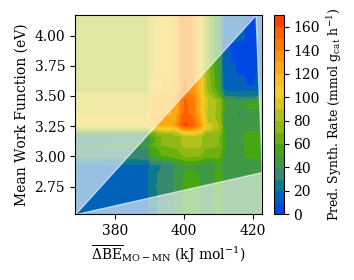

In [63]:
# 2d plot of model predictions vs. both features

# ensure model is trained on Xy_all
rf1.fit(Xy_all.loc[:,model_features1].values,Xy_all[target].values)

fig, ax = plt.subplots(figsize=(3.54,2.8))
pred = rf1.predict(X_hm1.loc[:,model_features1])

# ax.contourf(X_hm1['ON_BondEnergyDelta_mean'],X_hm1['M_WorkFunction_mean'],pred)
# ax.scatter(X_hm1['ON_BondEnergyDelta_mean'],X_hm1['M_WorkFunction_mean'],c=pred)
n_steps = 50
x = np.linspace(X_hm1['ON_BondEnergyDelta_mean'].min(),X_hm1['ON_BondEnergyDelta_mean'].max(),n_steps)
y = np.linspace(X_hm1['M_WorkFunction_mean'].min(),X_hm1['M_WorkFunction_mean'].max(),n_steps)
xx,yy = np.meshgrid(x,y)
grid_X = np.stack((xx.ravel(),yy.ravel())).T
z = rf1.predict(grid_X)
zz = z.reshape(n_steps,n_steps)

mask = np.zeros_like(zz)
# mask[yy>x*0.0317-9.14] = True

zzm = np.ma.array(zz,mask=mask)
# ax.scatter(xx,yy,c=zz)
cf = ax.contourf(xx,yy,zzm,levels=15,corner_mask=True)


ymin = np.min(y)
ymax = np.max(y)

xt = np.linspace(368.493,420.7483)
xb = np.linspace(368.493,422.59667)
xr = np.linspace(420.74833,422.59667)

# ax.plot(xt,xt*0.03157574-9.11544,c='white')
# ax.plot(xb,xb*0.006469+0.13621,c='white')
# ax.plot(xr,xr*(-0.703197)+300.038875,c='white')
alpha = 0.6
ax.fill_between(xt,xt*0.03157574-9.11544,ymax,color='white',alpha=alpha)
ax.fill_between(xb,xb*0.006469+0.13621,ymin,color='white',alpha=alpha)
ax.fill_between(xr,xr*(-0.703197)+300.038875,ymax,color='white',alpha=alpha)

ax.set_xlabel('$\overline{\Delta\mathrm{BE}}_{\mathrm{MO-MN}}$ (kJ mol$^{-1}$)')
ax.set_ylabel('Mean Work Function (eV)')

cbar = fig.colorbar(cf)
cbar.set_label('Pred. Synth. Rate (mmol $\mathrm{g}_{\mathrm{cat}}$ h$^{-1}$)',size=9)
cbar
fig.tight_layout()
fig.savefig(os.path.join(plotdir,'2d_PDP.jpg'),dpi=500)

## 1.7 Extrapolate to predict Mg, B, and Sr ternaries

In [64]:
scale = 50
# substitute Mg for Ca
coords, X_simplex_Mg = featurize_simplex(scale,bf,tern_axes=['Mg','Ba','Al'])
X_hm_Mg = X_simplex_Mg.loc[:,model_features1]
# substitute Sr for Ba
coords, X_simplex_Sr = featurize_simplex(scale,bf,tern_axes=['Al','Ca','Sr'])
X_hm_Sr = X_simplex_Sr.loc[:,model_features1]
# substitute B for Al
coords, X_simplex_B = featurize_simplex(scale,bf,tern_axes=['Ba','B','Ca'])
X_hm_B = X_simplex_B.loc[:,model_features1]

<IPython.core.display.Javascript object>


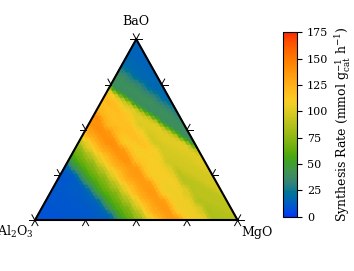

In [65]:
# substitute Mg for Ca
fig,ax = plt.subplots(figsize=(3.54,3.54*6.9/9))

vlim = (0,175)
label_fs = 9
tick_fs = 8

# ensure model is fit to Xy_all
rf1.fit(Xy_all.loc[:,model_features1].values,Xy_all[target].values)

tax = estimator_ternary_heatmap(50,rf1,use_X=X_hm_Mg,ax=ax,add_labeloffset=0.05,vlim=vlim,cmap=cc.m_rainbow,
                               labelsize=label_fs,tern_axes=['Mg','Ba','Al'],tern_labels = ['MgO','BaO','Al$_2$O$_3$'])

tax.ticks(multiple=tax.get_scale()/4,tick_formats='',offset=0.03,lw=0.7)
tax.ticks(multiple=tax.get_scale()/4,tick_formats='',offset=0.03,lw=0.7,clockwise=True)

add_colorbar(ax=ax,vlim=vlim,cbrect=[0.8,0.2,0.04,0.68],
             subplots_adjust={'left':0.07,'wspace':0.35, 'hspace':0.25, 'right':0.7},
             label='Synthesis Rate ($\mathrm{mmol} \ \mathrm{g}_{\mathrm{cat}}^{-1} \ \mathrm{h}^{-1}$)',
             label_kwargs={'size':label_fs},tick_params={'labelsize':tick_fs})

fig.savefig(os.path.join(plotdir,'Mg_ML_heatmap.jpg'),dpi=500,transparent=True)

<IPython.core.display.Javascript object>


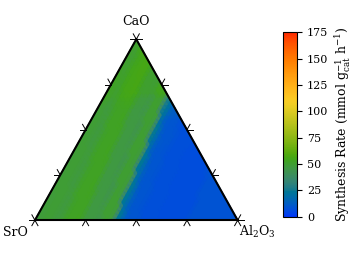

In [66]:
# substitute Sr for Ba
fig,ax = plt.subplots(figsize=(3.54,3.54*6.9/9))

vlim = (0,175)
label_fs = 9
tick_fs = 8

# ensure model is fit to Xy_all
rf1.fit(Xy_all.loc[:,model_features1].values,Xy_all[target].values)

tax = estimator_ternary_heatmap(50,rf1,use_X=X_hm_Sr,ax=ax,add_labeloffset=0.05,vlim=vlim,cmap=cc.m_rainbow,
                               labelsize=label_fs,tern_axes=['Al','Ca','Sr'],tern_labels = ['Al$_2$O$_3$','CaO','SrO'])

tax.ticks(multiple=tax.get_scale()/4,tick_formats='',offset=0.03,lw=0.7)
tax.ticks(multiple=tax.get_scale()/4,tick_formats='',offset=0.03,lw=0.7,clockwise=True)

add_colorbar(ax=ax,vlim=vlim,cbrect=[0.8,0.2,0.04,0.68],
             subplots_adjust={'left':0.07,'wspace':0.35, 'hspace':0.25, 'right':0.7},
             label='Synthesis Rate ($\mathrm{mmol} \ \mathrm{g}_{\mathrm{cat}}^{-1} \ \mathrm{h}^{-1}$)',
             label_kwargs={'size':label_fs},tick_params={'labelsize':tick_fs})

fig.savefig(os.path.join(plotdir,'Sr_ML_heatmap.jpg'),dpi=500,transparent=True)

<IPython.core.display.Javascript object>


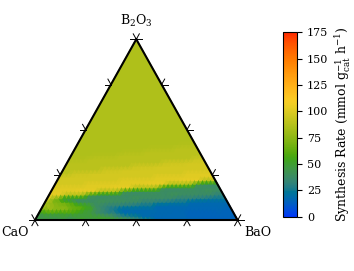

In [67]:
# substitute B for Al
fig,ax = plt.subplots(figsize=(3.54,3.54*6.9/9))

vlim = (0,175)
label_fs = 9
tick_fs = 8

# ensure model is fit to Xy_all
rf1.fit(Xy_all.loc[:,model_features1].values,Xy_all[target].values)

tax = estimator_ternary_heatmap(50,rf1,use_X=X_hm_B,ax=ax,add_labeloffset=0.05,vlim=vlim,cmap=cc.m_rainbow,
                               labelsize=label_fs,tern_labels = ['BaO','B$_2$O$_3$','CaO'])

tax.ticks(multiple=tax.get_scale()/4,tick_formats='',offset=0.03,lw=0.7)
tax.ticks(multiple=tax.get_scale()/4,tick_formats='',offset=0.03,lw=0.7,clockwise=True)

add_colorbar(ax=ax,vlim=vlim,cbrect=[0.8,0.2,0.04,0.68],
             subplots_adjust={'left':0.07,'wspace':0.35, 'hspace':0.25, 'right':0.7},
             label='Synthesis Rate ($\mathrm{mmol} \ \mathrm{g}_{\mathrm{cat}}^{-1} \ \mathrm{h}^{-1}$)',
             label_kwargs={'size':label_fs},tick_params={'labelsize':tick_fs})

fig.savefig(os.path.join(plotdir,'B_ML_heatmap.jpg'),dpi=500,transparent=True)

<IPython.core.display.Javascript object>


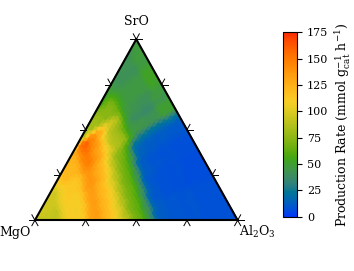

In [97]:
fig,ax = plt.subplots(figsize=(3.54,3.54*6.9/9))

vlim = (0,175)
label_fs = 9
tick_fs = 8

# ensure model is fit to Xy_all
rf1.fit(Xy_all.loc[:,model_features1].values,Xy_all[target].values)

tax = estimator_ternary_heatmap(50,rf1,bf,model_features1,tern_axes=['Al','Sr','Mg'],ax=ax,add_labeloffset=0.05,vlim=vlim,cmap=cc.m_rainbow,
                               labelsize=label_fs,tern_labels = ['Al$_2$O$_3$','SrO','MgO'])

tax.ticks(multiple=tax.get_scale()/4,tick_formats='',offset=0.03,lw=0.7)
tax.ticks(multiple=tax.get_scale()/4,tick_formats='',offset=0.03,lw=0.7,clockwise=True)

add_colorbar(ax=ax,vlim=vlim,cbrect=[0.8,0.2,0.04,0.68],
             subplots_adjust={'left':0.07,'wspace':0.35, 'hspace':0.25, 'right':0.7},
             label='Synthesis Rate ($\mathrm{mmol} \ \mathrm{g}_{\mathrm{cat}}^{-1} \ \mathrm{h}^{-1}$)',
             label_kwargs={'size':label_fs},tick_params={'labelsize':tick_fs})

fig.savefig(os.path.join(plotdir,'AlSrMg_ML_heatmap.jpg'),dpi=500,transparent=True)

<IPython.core.display.Javascript object>


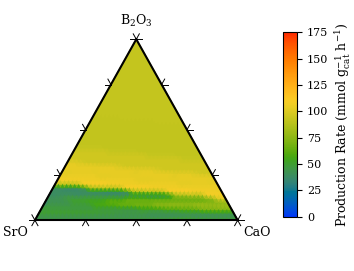

In [98]:
fig,ax = plt.subplots(figsize=(3.54,3.54*6.9/9))

vlim = (0,175)
label_fs = 9
tick_fs = 8

# ensure model is fit to Xy_all
rf1.fit(Xy_all.loc[:,model_features1].values,Xy_all[target].values)

tax = estimator_ternary_heatmap(50,rf1,bf,model_features1,tern_axes=['Ca','B','Sr'],ax=ax,add_labeloffset=0.05,vlim=vlim,cmap=cc.m_rainbow,
                               labelsize=label_fs,tern_labels = ['CaO','B$_2$O$_3$','SrO'])

tax.ticks(multiple=tax.get_scale()/4,tick_formats='',offset=0.03,lw=0.7)
tax.ticks(multiple=tax.get_scale()/4,tick_formats='',offset=0.03,lw=0.7,clockwise=True)

add_colorbar(ax=ax,vlim=vlim,cbrect=[0.8,0.2,0.04,0.68],
             subplots_adjust={'left':0.07,'wspace':0.35, 'hspace':0.25, 'right':0.7},
             label='Synthesis Rate ($\mathrm{mmol} \ \mathrm{g}_{\mathrm{cat}}^{-1} \ \mathrm{h}^{-1}$)',
             label_kwargs={'size':label_fs},tick_params={'labelsize':tick_fs})

fig.savefig(os.path.join(plotdir,'CaBSr_ML_heatmap.jpg'),dpi=500,transparent=True)

<IPython.core.display.Javascript object>


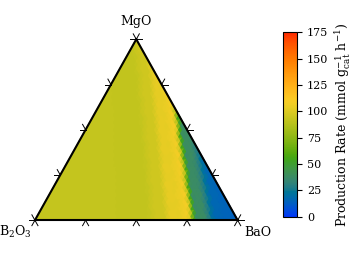

In [99]:
fig,ax = plt.subplots(figsize=(3.54,3.54*6.9/9))

vlim = (0,175)
label_fs = 9
tick_fs = 8

# ensure model is fit to Xy_all
rf1.fit(Xy_all.loc[:,model_features1].values,Xy_all[target].values)

tax = estimator_ternary_heatmap(50,rf1,bf,model_features1,tern_axes=['Ba','Mg','B'],ax=ax,add_labeloffset=0.05,vlim=vlim,cmap=cc.m_rainbow,
                               labelsize=label_fs,tern_labels = ['BaO','MgO','B$_2$O$_3$'])

tax.ticks(multiple=tax.get_scale()/4,tick_formats='',offset=0.03,lw=0.7)
tax.ticks(multiple=tax.get_scale()/4,tick_formats='',offset=0.03,lw=0.7,clockwise=True)

add_colorbar(ax=ax,vlim=vlim,cbrect=[0.8,0.2,0.04,0.68],
             subplots_adjust={'left':0.07,'wspace':0.35, 'hspace':0.25, 'right':0.7},
             label='Synthesis Rate ($\mathrm{mmol} \ \mathrm{g}_{\mathrm{cat}}^{-1} \ \mathrm{h}^{-1}$)',
             label_kwargs={'size':label_fs},tick_params={'labelsize':tick_fs})

fig.savefig(os.path.join(plotdir,'BaMgB_ML_heatmap.jpg'),dpi=500,transparent=True)

<IPython.core.display.Javascript object>


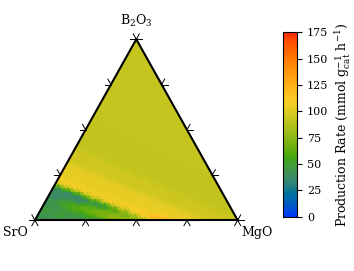

In [100]:
fig,ax = plt.subplots(figsize=(3.54,3.54*6.9/9))

vlim = (0,175)
label_fs = 9
tick_fs = 8

# ensure model is fit to Xy_all
rf1.fit(Xy_all.loc[:,model_features1].values,Xy_all[target].values)

tax = estimator_ternary_heatmap(50,rf1,bf,model_features1,tern_axes=['Mg','B','Sr'],ax=ax,add_labeloffset=0.05,vlim=vlim,cmap=cc.m_rainbow,
                               labelsize=label_fs,tern_labels = ['MgO','B$_2$O$_3$','SrO'])

tax.ticks(multiple=tax.get_scale()/4,tick_formats='',offset=0.03,lw=0.7)
tax.ticks(multiple=tax.get_scale()/4,tick_formats='',offset=0.03,lw=0.7,clockwise=True)

add_colorbar(ax=ax,vlim=vlim,cbrect=[0.8,0.2,0.04,0.68],
             subplots_adjust={'left':0.07,'wspace':0.35, 'hspace':0.25, 'right':0.7},
             label='Synthesis Rate ($\mathrm{mmol} \ \mathrm{g}_{\mathrm{cat}}^{-1} \ \mathrm{h}^{-1}$)',
             label_kwargs={'size':label_fs},tick_params={'labelsize':tick_fs})

# fig.savefig(os.path.join(plotdir,'BaMgB_ML_heatmap.jpg'),dpi=500,transparent=True)

# 2. Models with empirically selected features

## 2.1a Select from BCA feature set

In [106]:
# automatically select from BCA_Featurizer features
try:
    sfs_bf = load_pickle('sfs_bf.pkl')
except FileNotFoundError:
    sfs_bf_features = list(X_train.columns.values)

    rf_sfs = RandomForestRegressor(n_estimators=25,max_depth=10,random_state=11)

    # ensure that SFS instance uses same CV folds as everything else
    cv = mv.repeating_KFold(4,4,random_state=17)
    
    sfs_bf = SFS(rf_sfs,
              k_features=10,
              forward=True,
              floating=True,
              verbose=2,
              scoring='r2',
              cv=cv,
              n_jobs=4)

    sfs_bf.fit(X_train.loc[:,sfs_bf_features].values,y_train['max_rate'].values,
               custom_feature_names=sfs_bf_features)
    save_pickle(sfs_bf,'sfs_bf.pkl')

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   13.7s
[Parallel(n_jobs=4)]: Done  95 out of  95 | elapsed:   31.0s finished

[2020-08-18 11:36:42] Features: 1/10 -- score: 0.6062755801137046[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   10.1s
[Parallel(n_jobs=4)]: Done  94 out of  94 | elapsed:   27.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    3.2s finished

[2020-08-18 11:37:13] Features: 2/10 -- score: 0.6562366284085589[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   14.1s
[Parallel(n_jobs=4)]: Done  93 out of  93 | elapsed:   31.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2

Dumped pickle to sfs_bf2_0.2_noscale.pkl


[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:    3.0s finished

[2020-08-18 11:43:28] Features: 10/10 -- score: 0.5518342907308567

In [119]:
# perform grid search optimization for each selected k-feature set
rf2a = RandomForestRegressor(random_state=11)
# rs = RobustScaler()
# rfp2a = Pipeline([('scale',rs),('rf',rf2a)])

try:
    results_bf = load_pickle('sfs_results_bf.pkl')
except FileNotFoundError:
    hypers = []
    cv_scores = []
    val_scores = []
    test_scores = []
    test3_scores = []
    for k,v in sfs_bf.subsets_.items():
        # grid search hyperparams
        X_gs = X_train.loc[:,v['feature_names']].values
        y_gs = y_train[target].values
        w_gs = None #np.log(y_gs)

        gs_rf2 = mv.GridSearchRepeatedCV(rf2a,param_grid={'n_estimators':[40,50,60,70],
                                                        'max_features':np.arange(1,k+1,1).astype(int),
                                                        'max_depth':[3,5,7]
                                                       }
                                       )
        gs_rf2.fit(X_gs,y_gs,repeat=4,n_splits=4,random_state=17,
                    sample_weight=w_gs
                  )

        rf2a.set_params(**gs_rf2.best_params_)
        hypers.append(gs_rf2.best_params_)
        print(f'Best hyperparams for {k} features:',gs_rf2.best_params_)

        # get cv scores
        act,pred,agg_r2,agg_mae,lbs,ubs = mv.repeated_KFold_cv(rf2a,X_train.loc[:,list(v['feature_names'])].values,y_train[target].values,
                                                       repeat=4,sample_weight=None,#np.log(y_train[target]).values,
                                                       n_splits=4,random_state=17
                                                       )
        cv_scores.append(np.mean(agg_r2))
        # get holdout score
        rf2a.fit(X_train.loc[:,v['feature_names']].values,y_train[target].values)
        val_scores.append(rf2a.score(X_val.loc[:,v['feature_names']],y_val[target],
                                    sample_weight=None#np.log(y_val[target]).values
                                    )
                         )

        # get test score
        rf2a.fit(Xy_tv.loc[:,v['feature_names']].values,Xy_tv[target].values)
        test_scores.append(rf2a.score(X_test.loc[:,v['feature_names']],y_test[target],
                                     sample_weight=None#np.log(y_test[target]).values
                                     )
                          )
        test3_scores.append(rf2a.score(X_test.iloc[good_index,:].loc[:,v['feature_names']],
                                       y_test.iloc[good_index,:][target],
                                     sample_weight=None#np.log(y_test[target]).values
                                     )
                          )

    results_bf = pd.DataFrame(np.array([list(sfs_bf.subsets_.keys()),
                                        [sub['feature_names'] for sub in sfs_bf.subsets_.values()],
                                        hypers,cv_scores,val_scores,test_scores,test3_scores]).T,
                              columns=['n_features','features',\
                                       'hypers','cv_score','val_score','test_score','3pt_test_score']
                             )
    save_pickle(results_bf,'sfs_results_bf.pkl')

Best hyperparams for 1 features: {'n_estimators': 70, 'max_features': 1, 'max_depth': 3}
Best hyperparams for 2 features: {'n_estimators': 70, 'max_features': 2, 'max_depth': 7}
Best hyperparams for 3 features: {'n_estimators': 70, 'max_features': 3, 'max_depth': 5}
Best hyperparams for 4 features: {'n_estimators': 70, 'max_features': 2, 'max_depth': 7}
Best hyperparams for 5 features: {'n_estimators': 70, 'max_features': 5, 'max_depth': 5}
Best hyperparams for 6 features: {'n_estimators': 50, 'max_features': 6, 'max_depth': 5}
Best hyperparams for 7 features: {'n_estimators': 70, 'max_features': 5, 'max_depth': 5}
Best hyperparams for 8 features: {'n_estimators': 60, 'max_features': 5, 'max_depth': 5}
Best hyperparams for 9 features: {'n_estimators': 60, 'max_features': 4, 'max_depth': 7}
Best hyperparams for 10 features: {'n_estimators': 60, 'max_features': 9, 'max_depth': 5}
Dumped pickle to sfs_results_bf2_0.2_noscale.pkl


## 2.1b Select from generic feature set

In [115]:
gf = GenericFeaturizer()
gf.set_n_jobs(1)
print('Total generic features:',len(gf.feature_labels()))

"Set up train and validation datasets"
tv_features_gen = gf.featurize_dataframe(tv_data,col_id="composition",inplace=False)
X_train_gen = tv_features_gen.loc[X_train.index,'M_HOMO_energy':]
X_val_gen = tv_features_gen.loc[X_val.index,'M_HOMO_energy':]

# check all features are numeric
print("Feature datatypes:", X_train_gen.dtypes.unique())
# remove zero-var features
zero_var = list(X_train_gen.columns[X_train_gen.var()==0])
X_train_gen = X_train_gen.drop(zero_var,axis=1)
X_val_gen = X_val_gen.drop(zero_var,axis=1)
print("Zero variance features removed:", zero_var)
# remove null features
nulls = list(X_train_gen.columns[pd.isnull(X_train_gen).max()])
X_train_gen = X_train_gen.drop(nulls,axis=1)
X_val_gen = X_val_gen.drop(nulls,axis=1)
print("Null features removed:", nulls)
print('\nFinal number of features:', len(X_train_gen.columns))
Xy_train_gen = pd.concat([X_train_gen,y_train],axis=1)
Xy_val_gen = pd.concat([X_val_gen,y_val],axis=1)
Xy_tv_gen = pd.concat([Xy_train_gen,Xy_val_gen])

"Set up test dataset"
test_features_gen = gf.featurize_dataframe(test_data,col_id="composition",inplace=False)
# remove features that had zero variance in training data
X_test_gen = test_features_gen.loc[:,'M_HOMO_energy':]
X_test_gen = X_test_gen.drop(zero_var+nulls,axis=1)
y_test = test_features_gen[['max_rate','max_NH3_ppm']]
Xy_test_gen = pd.concat([X_test_gen,y_test],axis=1)

"Full dataset"
Xy_all_gen = pd.concat([Xy_tv_gen,Xy_test_gen])

Total generic features: 380



Feature datatypes: [dtype('float64')]
Zero variance features removed: ['M MagpieData minimum NsValence', 'M MagpieData maximum NsValence', 'M MagpieData range NsValence', 'M MagpieData mean NsValence', 'M MagpieData avg_dev NsValence', 'M MagpieData mode NsValence', 'M MagpieData minimum NdValence', 'M MagpieData maximum NdValence', 'M MagpieData range NdValence', 'M MagpieData mean NdValence', 'M MagpieData avg_dev NdValence', 'M MagpieData mode NdValence', 'M MagpieData minimum NfValence', 'M MagpieData maximum NfValence', 'M MagpieData range NfValence', 'M MagpieData mean NfValence', 'M MagpieData avg_dev NfValence', 'M MagpieData mode NfValence', 'M MagpieData minimum NsUnfilled', 'M MagpieData maximum NsUnfilled', 'M MagpieData range NsUnfilled', 'M MagpieData mean NsUnfilled', 'M MagpieData avg_dev NsUnfilled', 'M MagpieData mode NsUnfilled', 'M MagpieData minimum NdUnfilled', 'M MagpieData maximum NdUnfilled', 'M MagpieData range NdUnfilled', 'M MagpieData mean NdUnfilled', 'M 

In [116]:
try:
    sfs_gen = load_pickle('sfs_gen.pkl')
except FileNotFoundError:
    sfs_gen_features = list(X_train_gen.columns.values)

    rf_sfs_gen = RandomForestRegressor(n_estimators=25,max_depth=10,random_state=11)

    cv = mv.repeating_KFold(4,4,random_state=17)

    sfs_gen = SFS(rf_sfs_gen,
              k_features=10,
              forward=True,
              floating=True,
              verbose=2,
              scoring='r2',
              cv=cv,
              n_jobs=4)

    sfs_gen.fit(X_train_gen.loc[:,sfs_gen_features].values,y_train['max_rate'].values,
                custom_feature_names=sfs_gen_features)
    save_pickle(sfs_gen,'sfs_gen.pkl')

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   14.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   53.9s
[Parallel(n_jobs=4)]: Done 256 out of 256 | elapsed:  1.4min finished

[2020-08-18 13:34:27] Features: 1/10 -- score: 0.6062755801137046[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   10.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   44.0s
[Parallel(n_jobs=4)]: Done 255 out of 255 | elapsed:  1.2min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    3.9s finished

[2020-08-18 13:35:43] Features: 2/10 -- score: 0.6775532941933922[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   17.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 

Dumped pickle to sfs_gen2_0.2_noscale.pkl


[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:    3.1s finished

[2020-08-18 13:47:23] Features: 10/10 -- score: 0.695779325004507

In [120]:
# perform grid search optimization for each selected k-feature set

try:
    results_gen = load_pickle('sfs_results_gen.pkl')
except FileNotFoundError:
    rf2b = RandomForestRegressor(random_state=11)
#     rfp2b = Pipeline([('scale',rs),('rf',rf2b)])

    hypers = []
    cv_scores = []
    val_scores = []
    test_scores = []
    test3_scores = []
    for k,v in sfs_gen.subsets_.items():
        # grid search hyperparams
        X_gs = X_train_gen.loc[:,v['feature_names']].values
        y_gs = y_train[target].values
        w_gs = None#np.log(y_gs)

        gs_rf2 = mv.GridSearchRepeatedCV(rf2b,param_grid={'n_estimators':[40,50,60,70],
                                                        'max_features':np.arange(1,k+1,1).astype(int),
                                                        'max_depth':[3,5,7]
                                                       }
                                       )
        gs_rf2.fit(X_gs,y_gs,repeat=4,n_splits=4,random_state=17,
                    sample_weight=w_gs
                  )

        rf2b.set_params(**gs_rf2.best_params_)
        hypers.append(gs_rf2.best_params_)
        print(f'Best hyperparams for {k} features:',gs_rf2.best_params_)

        # get cv scores
        act,pred,agg_r2,agg_mae,lbs,ubs = mv.repeated_KFold_cv(rf2b,X_train_gen.loc[:,list(v['feature_names'])].values,
                                                               y_train[target].values,repeat=4,sample_weight=None,
                                                               n_splits=4,random_state=17
                                                               )
        cv_scores.append(np.mean(agg_r2))
        # get holdout score
        rf2b.fit(X_train_gen.loc[:,v['feature_names']].values,y_train[target].values)
        val_scores.append(rf2b.score(X_val_gen.loc[:,v['feature_names']],y_val[target],
                                    sample_weight=None
                                    )
                         )

        # get test score
        rf2b.fit(Xy_tv_gen.loc[:,v['feature_names']].values,Xy_tv[target].values)
        test_scores.append(rf2b.score(X_test_gen.loc[:,v['feature_names']],y_test[target],
                                     sample_weight=None
                                     )
                          )
        test3_scores.append(rf2b.score(X_test_gen.iloc[good_index,:].loc[:,v['feature_names']],
                                       y_test.iloc[good_index,:][target],
                                     sample_weight=None
                                     )
                          )

    results_gen = pd.DataFrame(np.array([list(sfs_gen.subsets_.keys()),[sub['feature_names'] for sub in sfs_gen.subsets_.values()],
                                         hypers,cv_scores,val_scores,test_scores,test3_scores]).T,
                              columns=['n_features','features',
                                       'hypers','cv_score','val_score','test_score','3pt_test_score']
                          )

    save_pickle(results_gen,'sfs_results_gen.pkl')

Best hyperparams for 1 features: {'n_estimators': 70, 'max_features': 1, 'max_depth': 3}
Best hyperparams for 2 features: {'n_estimators': 50, 'max_features': 2, 'max_depth': 7}
Best hyperparams for 3 features: {'n_estimators': 70, 'max_features': 3, 'max_depth': 5}
Best hyperparams for 4 features: {'n_estimators': 60, 'max_features': 4, 'max_depth': 5}
Best hyperparams for 5 features: {'n_estimators': 50, 'max_features': 5, 'max_depth': 5}
Best hyperparams for 6 features: {'n_estimators': 50, 'max_features': 4, 'max_depth': 7}
Best hyperparams for 7 features: {'n_estimators': 50, 'max_features': 6, 'max_depth': 5}
Best hyperparams for 8 features: {'n_estimators': 50, 'max_features': 6, 'max_depth': 5}
Best hyperparams for 9 features: {'n_estimators': 50, 'max_features': 9, 'max_depth': 5}
Best hyperparams for 10 features: {'n_estimators': 50, 'max_features': 10, 'max_depth': 5}
Dumped pickle to sfs_results_gen2_0.2_noscale.pkl


## 2.2 Compare empirical model scores to physical model

<IPython.core.display.Javascript object>


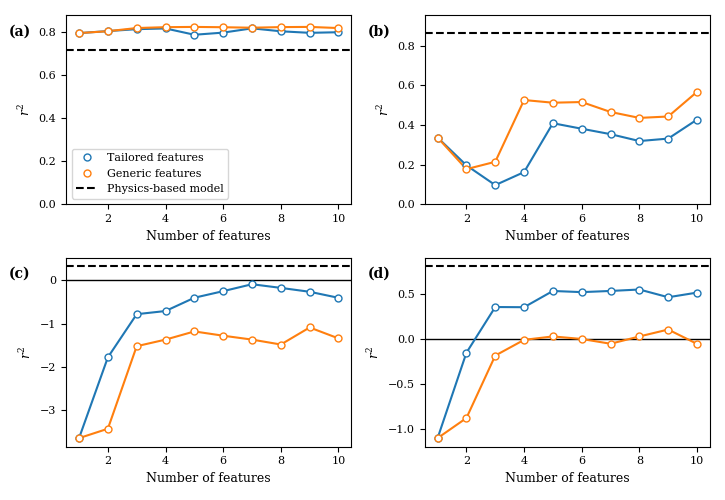

In [122]:
tick_fs = 8
label_fs = 9
fig, axes = plt.subplots(2,2,figsize=(7.25,5))
for result,label in zip([results_bf,results_gen],['Tailored features','Generic features']):
    for col, ax in zip(['cv_score','val_score','test_score','3pt_test_score'],axes.ravel()):
        p = ax.plot(result['n_features'],result[col].values,zorder=0)
        ax.plot(result['n_features'],result[col],label=label,
                ls='',marker='o',markerfacecolor='white',ms=5,c=p[0].get_color(),zorder=1)
#     axes[1].plot(result['n_features'],result['val_score'],marker='o',fillstyle='none')
#     axes[2].plot(result['n_features'],result['test_score'],marker='o',fillstyle='none',label=label)

axes[0,0].axhline(custom_cv_score,c='k',ls='--',label='Physics-based model')
axes[0,1].axhline(custom_val_score,c='k',ls='--')
axes[1,0].axhline(custom_test_score,c='k',ls='--')
axes[1,1].axhline(custom_test3_score,c='k',ls='--')

for ax,title in zip(axes.ravel(),['Cross Validation','Holdout','Test','Test 3 Points']):
    ax.set_xlabel('Number of features',size=label_fs)
    ax.set_ylabel('$r^2$',size=label_fs)
    ax.set_xticks(np.arange(2,11,2))
    ax.tick_params(axis='both',labelsize=tick_fs)
#     ax.set_title(title,size=label_fs)
#     ax.set_ylim(0,1)
    
for ax in axes[0]:
    ax.set_ylim(0,ax.get_ylim()[1]+0.05)
    
# axes[0,0].set_ylim(0.5,0.8)
# axes[0,1].set_ylim(0.8,1)
# axes[1,0].set_ylim(-0.85,0.35)
# axes[1,1].set_ylim(-0.5,1)

for ax in axes[1]:
    ax.axhline(0,lw=1,c='k',zorder=-10)
    
axes[0,0].legend(fontsize=tick_fs)

for ax, let in zip(axes.ravel(),['a','b','c','d']):
    ax.text(-0.2,0.95,f'({let})',weight='bold',size=label_fs+1,transform=ax.transAxes,va='top')

fig.tight_layout()
fig.savefig(os.path.join(plotdir,'FigS6_EmpiricalModelScores.jpg'),dpi=300)

# Citations for packages used

In [ ]:
# packages found by makecite:
# matplotlib, numpy, pandas, scipy, seaborn, sklearn

In [ ]:
#need to cite manually: alepython, ternary, mlxtend, pymatgen, matminer, featurizers

In [26]:
citations = [
    # alepython
    "@software{alepython,"
      "author       = {Maxime Jumelle},"
      "title        = {ALEPython: Python Accumulated Local Effects package},"
      "month        = sep,"
      "year         = 2019,"
      "version      = {0.1.0},"
      "url          = {https://github.com/MaximeJumelle/alepython/}"
    "}",
    # ternary 
    "@software{marc_2019_2628066,"
      "author       = {Marc Harper and "
                      "Bryan Weinstein and "
                      "tgwoodcock and "
                      "Cory Simon and "
                      "chebee7i and "
                      "Wiley Morgan and "
                      "Vince Knight and "
                      "Nick Swanson-Hysell and "
                      "Matthew Evans and "
                      "jl-bernal and "
                      "ZGainsforth and "
                      "The Gitter Badger and "
                      "SaxonAnglo and "
                      "Maximiliano Greco and "
                      "Guido Zuidhof},"
      "title        = {python-ternary: Ternary plots in Python},"
      "month        = apr,"
      "year         = 2019,"
      "publisher    = {Zenodo},"
      "version      = {1.0.6},"
      "doi          = {10.5281/zenodo.2628066},"
      "url          = {https://doi.org/10.5281/zenodo.2628066}"
    "}",
    # mlxtend
    "@article{raschkas_2018_mlxtend,"
      "author       = {Sebastian Raschka},"
      "title        = {MLxtend: Providing machine learning and data science "
                      "utilities and extensions to Python’s  "
                      "scientific computing stack},"
      "journal      = {The Journal of Open Source Software},"
      "volume       = {3},"
      "number       = {24},"
      "month        = apr,"
      "year         = 2018,"
      "publisher    = {The Open Journal},"
      "doi          = {10.21105/joss.00638},"
      "url          = {http://joss.theoj.org/papers/10.21105/joss.00638}"
    "}",
    # matminer
    "@article{WARD201860,"
        "title = {Matminer: An open source toolkit for materials data mining},"
        "journal = {Computational Materials Science},"
        "volume = {152},"
        "pages = {60 - 69},"
        "year = {2018},"
        "issn = {0927-0256},"
        "doi = {https://doi.org/10.1016/j.commatsci.2018.05.018},"
        "url = {http://www.sciencedirect.com/science/article/pii/S0927025618303252},"
        "author = {Logan Ward and Alexander Dunn and Alireza Faghaninia and Nils E.R. Zimmermann and Saurabh Bajaj and Qi Wang and Joseph Montoya and Jiming Chen and Kyle Bystrom and Maxwell Dylla and Kyle Chard and Mark Asta and Kristin A. Persson and G. Jeffrey Snyder and Ian Foster and Anubhav Jain},"
        "keywords = {Data mining, Open source software, Machine learning, Materials informatics},"
    "}",
    # 
]
# featurizer citations (includes pymatgen)
citations += bf.citations()
# makecite 
citations += [
    "@software{makecite,"
      "author       = {Adrian Price-Whelan and "
                      "Alexandar Mechev and "
                      "Brigitta Sipocz and "
                      "Griffin Hosseinzadeh and "
                      "jumeroag and "
                      "Eric Bellm},"
      "title        = {adrn/makecite v0.5},"
      "month        = nov,"
      "year         = 2019,"
      "publisher    = {Zenodo},"
      "version      = {v0.5},"
      "doi          = {10.5281/zenodo.3533303},"
      "url          = {https://doi.org/10.5281/zenodo.3533303}"
    "}"]

In [28]:
with open('../citations/notebook_package_citations.bib','w') as f:
    f.write('\n\n'.join(citations))

In [24]:
# get bibtex tags for latex file
# these citations are far from perfect! quite a bit of manual cleanup to do after generating
with open(os.path.join('../citations/package_citations.bib'),'r') as f:
    cite_text = f.read()
entries = cite_text.split('@')
entries = [e for e in entries if e.find('{')>0]
get_tag = lambda x: x[x.find('{')+1:x.find(',')]
tags = [get_tag(e) for e in entries]
print('\n'.join(['\\cite{{{}}}'.format(tag) for tag in tags if len(tag)>0]))
print('\nBad entries:',[e for e in entries if len(get_tag(e))==0])

Created MatProjCalc instance
Created MatProjCalc instance
\cite{Hunter:2007}
\cite{numpy:2011}
\cite{pandas:2010}
\cite{scipy:2001}
\cite{seaborn:2018}
\cite{scikit-learn:2011}
\cite{alepython}
\cite{marc_2019_2628066}
\cite{raschkas_2018_mlxtend}
\cite{WARD201860}
\cite{Holzl1979}
\cite{doi:10.1080/00222346908205102}
\cite{Butler1978}
\cite{Jain2013}
\cite{Ong2012b}
\cite{Ong_2015}
\cite{PhysRevA.55.191}
\cite{Ward2016}
\cite{Zohourian2017}
\cite{deml_ohayre_wolverton_stevanovic_2016}
\cite{doi:10.1063/1.323539}
\cite{ward_agrawal_choudary_wolverton_2016}
\cite{Kittel}
\cite{AngstromSciences}

Bad entries: ['misc{, title = {{Knowledgedoor Cohesive energy handbook}}, url = {http://www.knowledgedoor.com/2/elements{\\_}handbook/cohesive{\\_}energy.html}}\n\n']
